In [1]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow as tf
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.metrics as K
import tarfile
import pandas as pd
from tensorflow.keras.metrics import CategoricalAccuracy, MeanIoU

In [2]:
path_to_tar_file = "/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar"
output_directory = "brats21-dataset-training-validation"

# Open the tar file in read mode
with tarfile.open(path_to_tar_file, "r") as tar_ref:
    # Extract all contents to the specified directory
    tar_ref.extractall(output_directory)

print(f"Extraction completed. Files are saved to {output_directory}")

Extraction completed. Files are saved to brats21-dataset-training-validation


In [3]:
VOLUME_START_AT = 60 
VOLUME_SLICES = 75 

In [4]:

data_path = "/kaggle/working/brats21-dataset-training-validation"
samples = [f for f in os.listdir(data_path) if not f.startswith('.')]
print("Number of samples:", len(samples))

Number of samples: 1251


In [5]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set 
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 850
Validation length: 251
Test length: 150


In [6]:


IMG_SIZE = 128


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=4, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.list_IDs))
        self.on_epoch_end()
        self.class_frequencies = np.zeros(4)  # For 4 classes

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        """
        Generates data for a batch of images and corresponding segmentation masks
        :param batch_ids: List of IDs for the current batch
        :return: Input data (X) and one-hot encoded segmentation masks (y)
        """
        # Initialize arrays for the inputs and labels
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))  # Updated for 4 channels
        y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))  # One-hot encoded masks
        
        # Loop over the batch IDs
        for c, sample_id in enumerate(batch_ids):
            sample_path = os.path.join(data_path, sample_id, sample_id)
            t1ce_path = sample_path + '_t1ce.nii.gz'
            flair_path = sample_path + '_flair.nii.gz'
            seg_path = sample_path + '_seg.nii.gz'
            t1_path = sample_path + '_t1.nii.gz'  # Corrected file extension
            t2_path = sample_path + '_t2.nii.gz'  # Corrected file extension
    
            # Load the images using nibabel
            try:
                t1ce = nib.load(t1ce_path).get_fdata()
                flair = nib.load(flair_path).get_fdata()
                seg = nib.load(seg_path).get_fdata()
                t1 = nib.load(t1_path).get_fdata()
                t2 = nib.load(t2_path).get_fdata()
            except FileNotFoundError:
                print(f"Warning: Files for {sample_id} are missing or cannot be loaded.")
                continue
    
            # Process each slice in the volume (from VOLUME_START_AT to VOLUME_START_AT + VOLUME_SLICES)
            for j in range(VOLUME_SLICES):
                # Resize the input images to the desired dimension
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim)
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], self.dim)
                X[j + VOLUME_SLICES * c, :, :, 2] = cv2.resize(t1[:, :, j + VOLUME_START_AT], self.dim)
                X[j + VOLUME_SLICES * c, :, :, 3] = cv2.resize(t2[:, :, j + VOLUME_START_AT], self.dim)
                
                # Resize the segmentation mask
                seg_slice = seg[:, :, j + VOLUME_START_AT]
    
                # Ensure that the segmentation mask values are within the expected range
                seg_slice = np.clip(seg_slice, 0, 3)  # Clip values to range [0, 3]
    
                # Update the class frequencies
                unique_classes = np.unique(seg_slice)
                for uc in unique_classes:
                    if int(uc) < 4:  # Ensure class is within the expected range
                        self.class_frequencies[int(uc)] += np.sum(seg_slice == uc)
    
                # One-hot encode the segmentation mask
                y[j + VOLUME_SLICES * c] = self.__one_hot_encoding(seg_slice)
    
        X = X.astype(np.float32)
        y = y.astype(np.float32)
        # Normalize the input images (if necessary)
        X = X / np.max(X) if np.max(X) > 0 else X
        return X, y

    def __one_hot_encoding(self, mask):
        mask_resized = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        one_hot_mask = np.zeros((IMG_SIZE, IMG_SIZE, 4))
        for i in range(4):
            one_hot_mask[:, :, i] = np.where(mask_resized == i, 1, 0)
        return one_hot_mask

    def repeat(self):
        while True:
            for index in range(len(self)):
                yield self.__getitem__(index)


training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)



In [7]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate, Input
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import tensorflow as tf

def build_unet(inputs, ker_init, dropout):
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv1)
    conv1 = BatchNormalization()(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                  kernel_regularizer=regularizers.l2(0.0001))(pool)
    conv = BatchNormalization()(conv)
    conv = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                  kernel_regularizer=regularizers.l2(0.0001))(conv)
    conv = BatchNormalization()(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv2)
    conv2 = BatchNormalization()(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv3)
    conv3 = BatchNormalization()(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(dropout)(conv5)

    # Decoder
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init,
                 kernel_regularizer=regularizers.l2(0.0001))(UpSampling2D(size=(2, 2))(drop5))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init,
                 kernel_regularizer=regularizers.l2(0.0001))(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init,
                kernel_regularizer=regularizers.l2(0.0001))(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                   kernel_regularizer=regularizers.l2(0.0001))(conv9)
    conv9 = BatchNormalization()(conv9)

    up = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init,
                kernel_regularizer=regularizers.l2(0.0001))(UpSampling2D(size=(2, 2))(conv9))
    merge = concatenate([conv1, up], axis=3)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                  kernel_regularizer=regularizers.l2(0.0001))(merge)
    conv = BatchNormalization()(conv)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init,
                  kernel_regularizer=regularizers.l2(0.0001))(conv)
    conv = BatchNormalization()(conv)

    # Output Layer
    conv10 = Conv2D(4, 1, activation='softmax')(conv)

    return Model(inputs=inputs, outputs=conv10)

In [8]:
import tensorflow as tf
import tensorflow.keras.backend as K


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # Ensure both are float32
    y_true_f = tf.cast(y_true_f, dtype='float32')
    y_pred_f = tf.cast(y_pred_f, dtype='float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    
    return precision

def sensitivity(y_true, y_pred):
    
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


In [9]:

counts = np.array([8868079, 11639, 27873, 20409])


class_weights = 1. / counts
class_weights /= np.sum(class_weights)  

print("Class weights:", class_weights)
class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)

Class weights: [0.0006598  0.50272157 0.20992274 0.28669589]


In [10]:
import tensorflow as tf
from tensorflow.keras.losses import Loss

def weighted_categorical_crossentropy(class_weights):

    class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Flatten the tensors to turn the problem into a 2D classification
        y_true_flat = tf.reshape(y_true, [-1, tf.shape(y_pred)[-1]])
        y_pred_flat = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

        # Compute the categorical crossentropy loss
        cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
        unweighted_loss = cce(y_true_flat, y_pred_flat)

        # Compute weights: multiply by the class weights
        weights = tf.reduce_sum(y_true_flat * class_weights_tensor, axis=-1)

        # Apply the weights to the unweighted loss
        weighted_loss = unweighted_loss * weights

        # Return the mean loss over the batch
        return tf.reduce_mean(weighted_loss)
    
    return loss

In [11]:
from sklearn.utils.class_weight import compute_class_weight
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 4))

# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.3)

model.compile(
    loss=weighted_categorical_crossentropy(class_weights),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0),  # Gradient clipping
    
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
    ],
)

In [12]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1
    ),
    
    keras.callbacks.ModelCheckpoint(
        filepath='model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    ),
    
    CSVLogger('training.log', separator=',', append=False)
]


In [13]:

steps_per_epoch = len(training_generator)
validation_steps = len(valid_generator)
training_generator = training_generator.repeat()
valid_generator = valid_generator.repeat()

# Train the model
model.fit(
    training_generator,
    validation_data=valid_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1  
)


Epoch 1/10


I0000 00:00:1734697330.060956      66 service.cc:145] XLA service 0x79bbf0010d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734697330.061533      66 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734697330.061540      66 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734697378.608679      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.5150 - dice_coef: 0.3358 - loss: 0.3969 - mean_io_u: 0.2512 - precision: 0.4666 - sensitivity: 0.2513 - specificity: 0.9077
Epoch 1: val_loss improved from inf to 0.06709, saving model to model_.01-0.067086.weights.h5
850/850 ━━━━━━━━━━━━━━━━━━━━ 840s 916ms/step - accuracy: 0.5151 - dice_coef: 0.3359 - loss: 0.3967 - mean_io_u: 0.2512 - precision: 0.4667 - sensitivity: 0.2513 - specificity: 0.9078 - val_accuracy: 0.7337 - val_dice_coef: 0.3847 - val_loss: 0.0671 - val_mean_io_u: 0.2500 - val_precision: 0.6402 - val_sensitivity: 0.3159 - val_specificity: 0.9397 - learning_rate: 1.0000e-04
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.7374 - dice_coef: 0.3826 - loss: 0.0514 - mean_io_u: 0.2512 - precision: 0.5309 - sensitivity: 0.2320 - specificity: 0.9347
Epoch 2: val_loss improved from 0.06709 to 0.03247, saving model to model_.02-0.032469.weights.h5
850/850 ━━━━━━━━━━━━━━━━━━━━ 765s 900ms/step - accuracy: 0

In [14]:
test_results = model.evaluate(test_generator, steps=len(test_generator))
print("Test results:", test_results)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 107s 713ms/step - accuracy: 0.9034 - dice_coef: 0.8444 - loss: 0.0128 - mean_io_u: 0.2566 - precision: 0.9157 - sensitivity: 0.8957 - specificity: 0.9727
Test results: [0.013385322876274586, 0.8949035406112671, 0.25, 0.8363922238349915, 0.9065459370613098, 0.8876463770866394, 0.9696257710456848]


In [15]:
def plot_segmentation_results(X, y_true, y_pred, num_images=5):
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        # Original image
        axes[i, 0].imshow(X[i, :, :, 0], cmap='gray')  # Display the first channel (e.g., flair)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Ground truth segmentation
        axes[i, 1].imshow(y_true[i], cmap='viridis', vmin=0, vmax=3)
        axes[i, 1].set_title('Ground Truth Segmentation')
        axes[i, 1].axis('off')

        # Predicted segmentation
        axes[i, 2].imshow(y_pred[i], cmap='viridis', vmin=0, vmax=3)
        axes[i, 2].set_title('Predicted Segmentation')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step


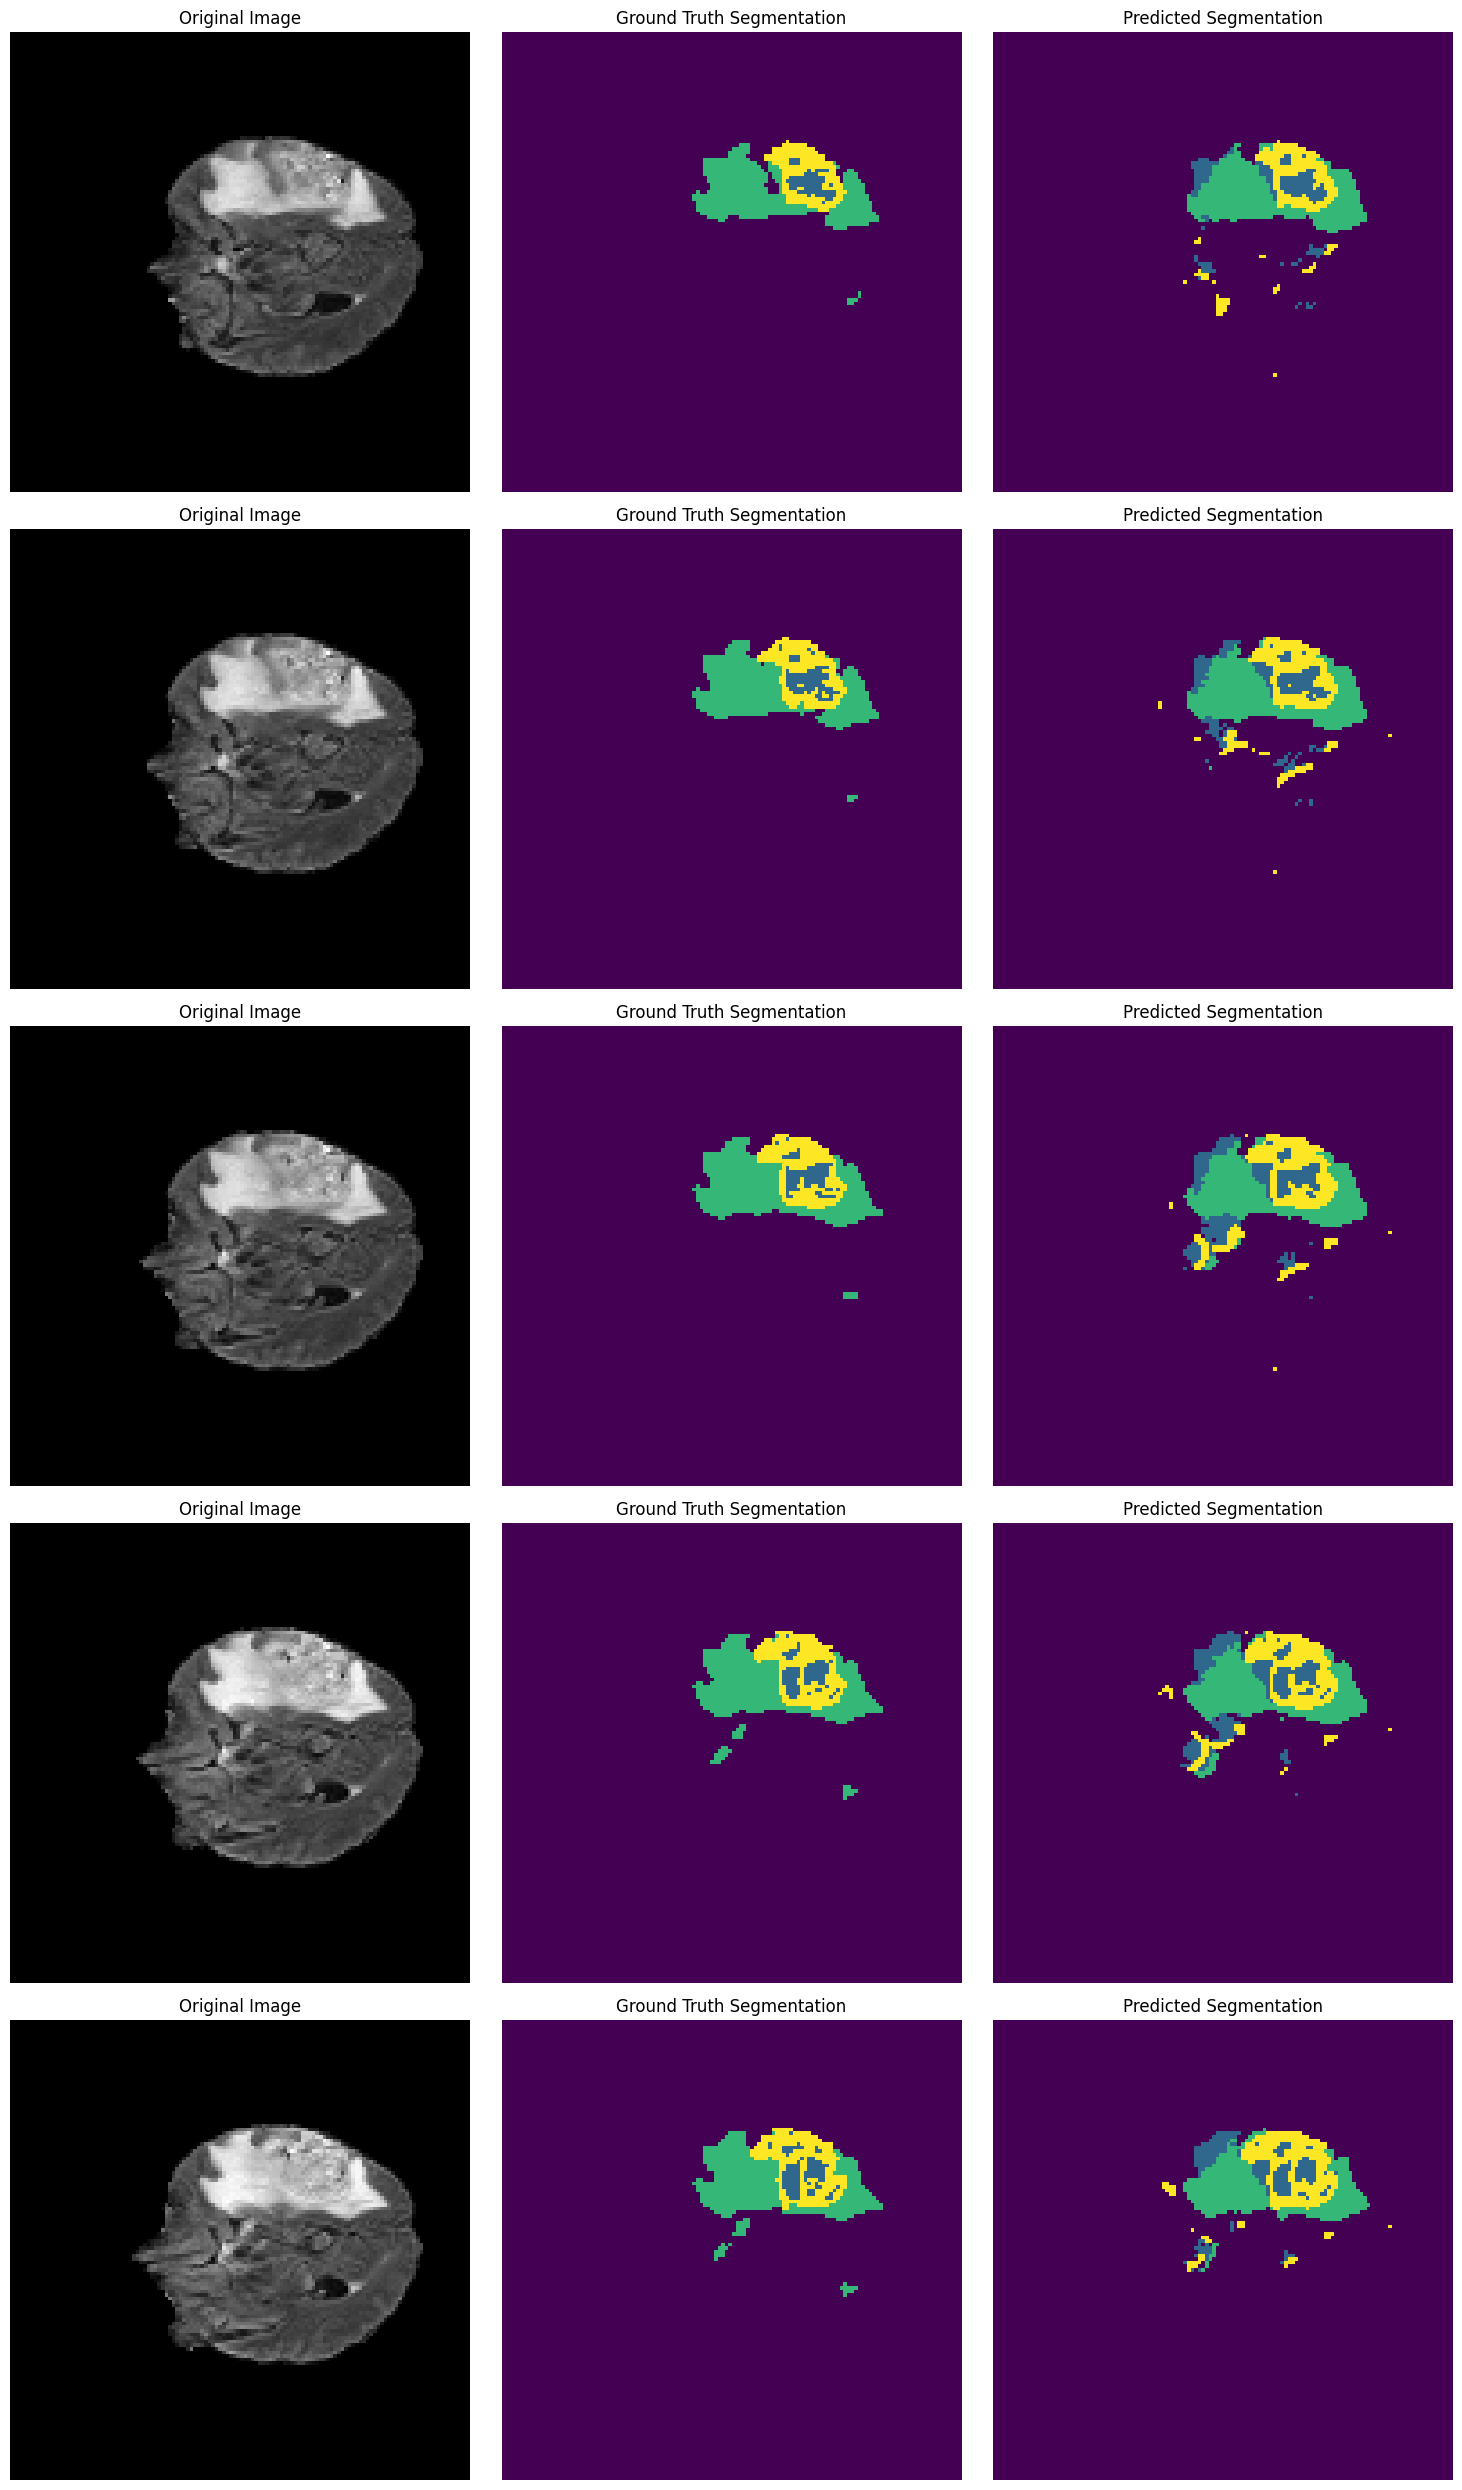

In [16]:
# Convert the test_generator to an iterator
test_iterator = iter(test_generator)

# Get a batch of images and their ground truth masks from the test iterator
X_test, y_true = next(test_iterator)

# Predict the segmentation masks for the test images
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=-1)
y_true_labels = np.argmax(y_true, axis=-1)

# Plot the results
plot_segmentation_results(X_test, y_true_labels, y_pred_labels, num_images=5)